# Анализ системы прогнозирования вероятности ДТП

## Введение

Заказчик проекта: каршеринговая компания.

Заказчик хочет понять, можно ли ли предсказывать ДТП, опираясь на исторические данные об авариях и участвовавших в них водителях и транспортных средств.

Чтобы это понять, заказчик ставит перед нами задачу:
- провести статистический анализ факторов, влияющих на ДТП;
- построить не менее трех моделей, оценивающих вероятность ДТП с любым повреждением транспортного средства, кроме царапин.
- выбрать лучшую модель,
- сделать анализ факторов, влияющих на предсказания лучшей модели,
- сформулировать для заказчика вывод о возможности предсказывать ДТП на основе анализа факторов и результатов модели, и дать рекомендации по расширению собираемых данных для решения или улучшения решения задачи предсказания ДТП.

Заказчика интересуют ДТП с типом виновника — только машина (car) и случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).

Для моделирования заказчик требует ограничиться данными за 2012 год.

Также заказчик выдвигает обязательное условие — учесть фактор возраста автомобиля.

### Цель проекта

Целью проекта является разработка аргументированного заключения о возможности предсказания ДТП на основании исторических данных об авариях и участвовавших в них водителях и транспортных средств, содержащего:
- анализ факторв, влияющих на ДТП, 
- пример моделей и оценку их качества,
- рекомендации по дополнительным данным, способствующим решению задачи.

### Основные этапы

В проекте мы выполнили следующие основные этапы:
- изучили предоставленные заказчиком данные;
- выполнили статистический анализ факторов, влияющих на ДТП;
- подготовили данные для обучения моделей;
- разработали три модели предсказания ДТП;
- проанализировали важность факторов для лучшей модели.

### Выводы

## Подготовка кода

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

In [2]:
from dotenv import load_dotenv
from os import getenv

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns

In [4]:
from sklearn.model_selection import (train_test_split, cross_validate,
                                     RepeatedKFold, RandomizedSearchCV)
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.impute import SimpleImputer

from sklearn.metrics import (get_scorer_names, accuracy_score, roc_auc_score,
                             confusion_matrix, classification_report)

In [5]:
import pickle

In [6]:
import shap

/Volumes/T7/working/yp15-motor-vehicle-collisions/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Инициализация

In [7]:
load_dotenv()
DB_CONFIG = {k : getenv(f"DB_{k.upper()}") for k in ['user','pwd','host','port','db']}


In [8]:
RANDOM_STATE = np.random.RandomState(829392)

### Функции и классы

#### DataSource

In [9]:
class DataSource:
    """Provides database information  
    
    Stores info in self._table as dictionary:
    - table_name:
        - rows_number: int
        - fields:
            - field_name: 
                - uniques: int
                - nans: int
                - type: str
             - ...
    - ...
               
    """
    def __init__(self, user: str, pwd: str, host: str, port: int,
                 db: str) -> None:
        """Creates DataSource instance and initialized connection to the source"""

        self._tables = dict()
        _connection_url = f"postgresql://{user}:{pwd}@{host}:{port}/{db}"
        self._engine = create_engine(_connection_url)

        # initialize database tables info
        with self._engine.connect() as connection:        
            self._init_tables_list(connection)
            self._init_tables_info(connection)

        
    def _init_tables_list(self, connection) -> None:
        """Get table list from database schema"""

        _query = """
            SELECT table_name
              FROM information_schema.tables
             WHERE table_schema='public'
               AND table_type='BASE TABLE';        
        """
        
        for row in connection.execute(_query):
                self._tables[row["table_name"]] = {
                    "fields": {},
                    "rows_number": None
                }

    def _init_table_rows_number(self, table_name: str, connection) -> None:
        """Counts number of rows in table_name"""

        _query = f"""
            SELECT COUNT(*) as rows_number
            FROM {table_name}
        """
        result = connection.execute(_query)
        self._tables[table_name]["rows_number"] = [
            _ for row in result for _ in row
        ][0]

            
    def _init_table_fields_info(self, table_name: str, connection) -> None:
        """Get tables fields from database schema"""

        _query = f"""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_name='{table_name}'        
        """
        
        for row in connection.execute(_query):
            self._tables[table_name]["fields"][row["column_name"]] = {
                "type": row["data_type"],
                "uniques": 0,
                "nans": 0
            }

    def _init_table_uniques(self, table_name: str, connection) -> None:
        """Counts unique values in table_name fields"""

        _query = "SELECT {} FROM {}".format(
            ", ".join([
                f"COUNT(DISTINCT {_}) as unique_{_}"
                for _ in self._tables[table_name]["fields"].keys()
            ]), table_name)

        for row in connection.execute(_query):
            for field in self._tables[table_name]["fields"].keys():
                row_key = f"unique_{field}"
                self._tables[table_name]["fields"][field]["uniques"] = row[
                    row_key]

    def _init_table_nans(self, table_name: str, connection) -> None:
        """Counts number of NULL values in table_name fields"""
        
        for field in self._tables[table_name]["fields"].keys():
            _query = f"""
                SELECT COUNT(*) 
                FROM {table_name} 
                WHERE {field} IS NULL        
            """
            result = connection.execute(_query)
            self._tables[table_name]["fields"][field]["nans"] = [
                _ for row in result for _ in row
            ][0]
        

    def _init_tables_info(self, connection) -> None:
        """Get tables info from database schema"""

        for table_name in self.tables:
            print(f"Get info for {table_name}")
            print("... rows number")
            self._init_table_rows_number(table_name, connection)
            print("... fields info")
            self._init_table_fields_info(table_name, connection)
            print("... number of unique values")
            self._init_table_uniques(table_name, connection)
            print("... number of nan values")
            self._init_table_nans(table_name, connection)
            print("done")

    @property
    def tables(self) -> list:
        """Returns list of tables in the database"""
        return [*self._tables]

    def exec_query(self, query: str) -> pd.DataFrame:
        """Executes SQL query and return DataFrame"""
        return pd.read_sql_query(query, con=self._engine)

    def table_head(self, table_name: str, number: int = 5) -> pd.DataFrame:
        """Returns first number of records in table_name"""
        return self.exec_query(f"SELECT * FROM {table_name} LIMIT {number}")

    def table_info(self, table_name: str) -> None:
        """Prints table info"""

        max_field_len = max(
            [len(_) for _ in self._tables[table_name]["fields"].keys()])

        max_type_len = max([
            len(self._tables[table_name]["fields"][field]["type"])
            for field in self._tables[table_name]["fields"].keys()
        ])

        rows_title = f"Field{' '*(max_field_len - len('Field'))}" + \
            "     Uniques     NaNs" + \
            "  Type" + (" "  * (max_type_len - len("Type")))
        print(f"Table: {table_name}")
        print(f"{self._tables[table_name]['rows_number']:,d} rows")
        print("-" * len(rows_title))
        print(rows_title)
        print("-" * len(rows_title))

        for k, v in self._tables[table_name]["fields"].items():
            print(f"{k}{' '*(max_field_len - len(k))}  " +
                  f"{v['uniques']:10,d} {v['nans']:8,d}  {v['type']}")
        print()

#### cross_validate_model

In [10]:
def cross_validate_model(estimator, X, y, cv, verbose=True, fit_params=dict()):
    cv_results = cross_validate(estimator,
                                X,
                                y,
                                cv=cv,
                                return_train_score=True,
                                scoring=['accuracy', 'roc_auc'],
                                fit_params=fit_params,
                                n_jobs=-1)
    if verbose:
        print(
            f"""
{str(estimator)}
fit time\t {cv_results['fit_time'].mean():.2f}s +/- {cv_results['fit_time'].std():.2f}s
score time\t {cv_results['score_time'].mean():.2f}s +/- {cv_results['score_time'].std():.2f}s
Accuracy\t {cv_results['test_accuracy'].mean():.2f} +/- {cv_results['test_accuracy'].std():.2f}
ROC AUC \t {cv_results['test_roc_auc'].mean():.2f} +/- {cv_results['test_roc_auc'].std():.2f}
""")

    return cv_results

#### plot_searh_curve

In [11]:
def plot_searh_curve(df: pd.DataFrame, ax: plt.axes, model_name: str) -> None:
    ax.set_title(model_name.upper())
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("experiment number")
    x_range = range(df.shape[0])
    ax.grid(True)

    ax.plot(x_range,
            df.mean_train_score,
            'r-',
            lw=3,
            marker='o',
            markersize=9,
            label='train mean')
    ax.fill_between(x_range,
                    df.mean_train_score - df.std_train_score,
                    df.mean_train_score + df.std_train_score,
                    alpha=0.2,
                    color='red',
                    label='train std')

    ax.plot(x_range,
            df.mean_test_score,
            'g-',
            lw=3,
            marker='o',
            markersize=9,
            label='valid mean')
    ax.fill_between(x_range,
                    df.mean_test_score - df.std_test_score,
                    df.mean_test_score + df.std_test_score,
                    alpha=0.2,
                    color='green',
                    label='valid std')
    ax.legend(loc='upper left')

    ax2 = ax.twinx()
    ax2.plot(x_range, df.mean_fit_time, lw=3, alpha=.5, label='fit time')
    ax2.plot(x_range, df.mean_score_time, lw=3, alpha=.5, label='score time')
    ax2.set_ylabel('time, s')
    ax2.legend(loc='upper right')

## Первичное исследование данных

### Описание данных от заказчика

Заказчик предоставил нам следующую схему и описание данных.

![ER-диаграмма](https://pictures.s3.yandex.net/resources/1.7_2880border_1_1654004672.png)

#### collisions — общая информация о ДТП
Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда

|Описание |Обозначение в таблице |Значения|
|:---|:---|:---|
|Идентификационный номер в базе данных| CASE_ID| Уникальный номер для зарегистрированного происшествия в таблице происшествий.|
|Дата происшествия|COLLISION_DATE|Формат год/месяц/день|
|Время происшествия|COLLISION_TIME|Формат: 24-часовой|
|Является ли место происшествие перекрёстком|INTERSECTION|Y — Intersection (перекрёсток)<br/>N — Not Intersection (не перекрёсток)<br/>-- — Not stated (Не указано)|
|Погода|WEATHER_1|A — Clear (Ясно)<br/>B — Cloudy (Облачно)<br/>C — Raining (Дождь)<br/>D — Snowing (Снегопад)<br/>E — Fog (Туман)<br/>F — Other (Другое)<br/>G — Wind (Ветер)- — Not Stated (Не указано)|
|Серьёзность происшествия|COLLISION_DAMAGE|1 — FATAL ТС (Не подлежит восстановлению)<br/>2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)<br/>3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)<br/>4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)<br/>0 – SCRATCH (Царапина)|
|Основной фактор аварии|PRIMARY_COLL_FACTOR|A — Code Violation (Нарушение правил ПДД)<br/>B — Other Improper Driving (Другое неправильное вождение)<br/>C — Other Than Driver (Кроме водителя)<br/>D — Unknown (Неизвестно)<br/>E — Fell Asleep (Заснул)<br/>- — Not Stated (Не указано)|
|Состояние дороги|ROAD_SURFACE|A — Dry (Сухая)<br/>B — Wet (Мокрая)<br/>C — Snowy or Icy (Заснеженная или обледенелая)<br/>D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)<br/>- — Not Stated (Не указано)|
<br/>Освещение|LIGHTING|A — Daylight (Дневной свет)<br/>B — Dusk-Dawn (Сумерки-Рассвет)<br/>C — Dark-Street Lights (Темно-Уличные фонари)<br/>D — Dark-No Street Lights (Темно-Нет уличных фонарей)<br/>E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)<br/>- — Not Stated (Не указано)|
|Номер географических районов, где произошло ДТП|COUNTY_CITY_LOCATION|число|
|Названия географических районов, где произошло ДТП|COUNTY_LOCATION|список разных названий, категориальный тип данных|
|Направление движения|DIRECTION|N — North (Север)<br/>E — East (Восток)<br/>S — South (Юг)<br/>W — West (Запад)<br/>- or blank — Not State (Не указано)<br/>на перекрёстке|
|Расстояние от главной дороги (метры)|DISTANCE|число|
|Тип дороги|LOCATION_TYPE|H — Highway (Шоссе)<br/>I — Intersection<br/> (Перекрёсток)<br/>R — Ramp (or Collector) (Рампа)<br/>- or blank — Not State Highway (Не указано)|
|Количество участников|PARTY_COUNT|число|
|Категория нарушения|PCF_VIOLATION_CATEGORY|01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)<br/>02 — Impeding Traffic (Препятствие движению транспорта)<br/>03 — Unsafe Speed (Превышение скорости)<br/>04 — Following Too Closely (Опасное сближение)<br/>05 — Wrong Side of Road (Неправильная сторона дороги)<br/>06 — Improper Passing (Неправильное движение)<br/>07 — Unsafe Lane Change (Небезопасная смена полосы движения)<br/>08 — Improper Turning (Неправильный поворот)<br/>09 — Automobile Right of Way (Автомобильное право проезда)<br/>10 — Pedestrian Right of Way (Пешеходное право проезда)<br/>11 — Pedestrian Violation (Нарушение пешеходами)<br/>12 — Traffic Signals and Signs (Дорожные сигналы и знаки)<br/>13 — Hazardous Parking (Неправильная парковка)<br/>14 — Lights (Освещение)<br/>15 — Brakes (Тормоза)<br/>16 — Other Equipment (Другое оборудование)<br/>17 — Other Hazardous Violation (Другие нарушения)<br/>18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)<br/>19 — Speeding (Скорость)<br/>20 — Pedestrian dui (Нарушение пешехода)<br/>21 — Unsafe Starting or Backing (Опасный старт)<br/>22 — Other Improper Driving (Другое неправильное вождение)<br/>23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)<br/>24 — Fell Asleep (Заснул)<br/>00 — Unknown (Неизвестно)<br/>- — Not Stated (Не указано)|
|Тип аварии|TYPE_OF_COLLISION|A — Head-On (Лоб в лоб)<br/>B — Sideswipe (Сторона)<br/>C — Rear End (Столкновение задней частью)<br/>D — Broadside (Боковой удар)<br/>E — Hit Object (Удар объекта)<br/>F — Overturned (Опрокинутый)<br/>G — Vehicle (транспортное средство/ Пешеход)<br/>H — Other (Другое)<br/>- — Not Stated (Не указано)|
|Дополнительные участники ДТП|MOTOR_VEHICLE_INVOLVED_WITH|Other motor vehicle (Другой автомобиль)<br/>Fixed object (Неподвижный объект)<br/>Parked motor vehicle (Припаркованный автомобиль)<br/>Pedestrian (Пешеход)<br/>Bicycle (Велосипедист)<br/>Non-collision (Не столкновение)<br/>Other object (Другой объект)<br/>Motor vehicle on other roadway (Автомобиль на другой проезжей)<br/>Animal (Животное)<br/>Train (Поезд)|
|Дорожное состояние|ROAD_CONDITION_1|A — Holes, Deep Ruts (Ямы, глубокая колея)<br/>B — Loose Material on Roadway (Сыпучий материал на проезжей части)<br/>C — Obstruction on Roadway (Препятствие на проезжей части)<br/>D — Construction or Repair Zone (Зона строительства или ремонта)<br/>E — Reduced Roadway Width (Уменьшенная ширина проезжей части)<br/>F — Flooded (Затоплено)<br/>G — Other (Другое)<br/>H — No Unusual Condition (Нет ничего необычного)<br/>- — Not Stated (Не указано)|
|Устройство управления|CONTROL_CONDITION_1|A — Functioning (Функционирует)<br/>B — Not Functioning (Не функционирует)<br/>C — Obscured (Затемнённый)<br/>D — None (Нет)<br/>- — Not Stated (Не указано)|

#### Parties — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

|Описание |Обозначение в таблице |Значения|
|:---|:---|:---|
|Идентификационный номер в базе данных|CASE_ID|Уникальный номер для зарегистрированного происшествия в таблице происшествий|
|Номер участника происшествия|PARTY_NUMBER|От 1 до N — по числу участников происшествия|
|Тип участника происшествия|PARTY_TYPE|1 — Car (Авто)<br/>2 — Road bumper (Дорожные знаки)<br/>3 — Building (Строения)<br/>4 — Road signs (Отбойник)<br/>5 — Other (Другое)<br/>6 — Operator (Оператор)<br/>- — Not Stated (Не указано)|
|Виновность участника|AT_FAULT|0/1|
|Сумма страховки (тыс. $)|INSURANCE_PREMIUM|число|
|Состояние участника: физическое или с учётом принятых лекарств|PARTY_DRUG_PHYSICAL|E — Under Drug Influence (Под воздействием лекарств)<br/>F — Impairment — Physical (Ухудшение состояния)<br/>G — Impairment Unknown (Не известно)<br/>H — Not Applicable (Не оценивался)<br/>I — Sleepy/Fatigued (Сонный/Усталый)<br/>- — Not Stated (Не указано)|
|Трезвость участника|PARTY_SOBRIETY|A — Had Not Been Drinking (Не пил)<br/>B — Had Been Drinking, Under Influence (Был пьян, под влиянием)<br/>C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)<br/>D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)<br/>G — Impairment Unknown (Неизвестно ухудшение)<br/>H — Not Applicable (Не оценивался)<br/>- — Not Stated (Не указано)|
|Наличие телефона в автомобиле (возможности разговаривать по громкой связи)|CELLPHONE_IN_USE|0/1|


#### Vehicles — информация о пострадавших машинах

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

|Описание |Обозначение в таблице |Значения|
|:---|:---|:---|
|Индекс текущей таблицы|ID|Номер в таблице|
|Идентификационный номер в базе данных|CASE_ID|Уникальный номер для зарегистрированного происшествия в таблице происшествий.|
|Тип кузова|VEHICLE_TYPE|MINIVAN<br/>COUPE<br/>SEDAN<br/>HATCHBACK<br/>OTHER|
|Тип КПП|VEHICLE_TRANSMISSION|auto (Автоматическая)<br/>manual (Ручная)<br/>- — Not Stated (Не указано)|
|Возраст автомобиля (в годах)|VEHICLE_AGE|число|

#### Обзор данных

Создадим объект класса DataSource для работы с предоставленными данными.

In [12]:
ds = DataSource(**DB_CONFIG)

Get info for case_ids
... rows number
... fields info
... number of unique values
... number of nan values
done
Get info for collisions
... rows number
... fields info
... number of unique values
... number of nan values
done
Get info for parties
... rows number
... fields info
... number of unique values
... number of nan values
done
Get info for vehicles
... rows number
... fields info
... number of unique values
... number of nan values
done


Проверим, какие таблицы с какими полями есть в базе данных.

In [13]:
for table_name in ds.tables:
    ds.table_info(table_name)

Table: case_ids
1,400,000 rows
----------------------------------
Field       Uniques     NaNs  Type
----------------------------------
case_id   1,400,000        0  text
db_year           1        0  text

Table: collisions
1,400,000 rows
------------------------------------------------------------------------
Field                           Uniques     NaNs  Type                  
------------------------------------------------------------------------
case_id                       1,400,000        0  text
county_city_location                538        0  text
county_location                      58        0  text
distance                          5,071        0  real
direction                             4  340,642  text
intersection                          2   12,219  integer
weather_1                             7    7,259  text
location_type                         3  881,221  text
collision_damage                      5        0  text
party_count                          18    

Мы видим, что состав таблиц и данные в них соответствуют обписанию. Есть одно расхождение в названиях полей в таблице `collisions`: поле в таблице `control_devive` в описании названо `control_condition_1`.

Таблица `collisions` содержит 1,4 млн. записей, все значения поля `case_id` уникальны. Такое же количество уникальных значений поля `case_id` мы видим в таблице `parties`, но количество записей больше почти в два раза в сравнении с `collisions`. В таблице `vehicals` 792,642 уникальных значений `case_id`. Наблюдаемые значения соответсвуют описанию: все случаи ДТП учтены в таблице с участниками, участников больше, чем случаев. Не все случаи ДТП бывают с автомобилями, поэтому видим меньшее количество записей. 

Количество уникальных значений поля `party_number` одинаково в таблицах `parties` и `vehicles`

Заметно расхождение в количестве уникальных значений для категориальных полей: как правило в данных на одно значение меньше, чем в описании. Есть гипотеза, что в реальных данных отсутствуют значения типа `-- — Not Stated (Не указано)`.

Отметим, что некоторые поля содержат большое количество пропусков, например `party_drug_physical` таблицы `parties` пропущено в 2,320,120 записей из 2,752,408 всего. 

Посмотрим на примеры данных.

In [14]:
for table_name in ds.tables:
    _sample = ds.table_head(table_name, 10)
    print(table_name)
    display(_sample)
    print()

case_ids


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021



collisions


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00



parties


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN



vehicles


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


Значения в таблицах в целом соответствуют описанию. У значений категориальных признаков отсутствуют коды-префиксы, но сами значения совпадают. Например для `weather_1` таблицы `collisions` мы видим значения "cloudy", "clear", а в описании — "A — Clear", "B — Cloudy" соответственно.

### Вывод

Мы проверили состав таблиц и данных в них и убедились, что:
- количество таблиц и набор полей в них соответствует условию задачи;
- все таблицы имеют набор данных;
- имеется общий ключ для связи таблиц.

## Статистичкский анализ факторов ДТП

Под аварией (ДТП) мы будем понимать следующие случаи:
- участник `parties.party_type` автомобиль ('car')
- тип повредждения `collisions.collision_damage` все, кроме царапин ('scratch')

### Количество ДТП по месяцам

Выясним, в какие месяцы происходит наибольшее количество аварий на всем периоде наблюдений.

Для этого:
1. определим дату первого и последнего ДТП в наших данных.
1. определим динамику ДТП по годам, чтобы убедится в однородности данных.
2. посчитаем количество аварий по месяцам за период наблюдений.

In [15]:
query = """
    SELECT 
        MIN(c.collision_date) AS start_date,
        MAX(c.collision_date) AS end_date
    FROM parties p 
        JOIN collisions c ON p.case_id = c.case_id 
    WHERE p.party_type = 'car'
        AND c.collision_damage != 'scratch'
    GROUP BY EXTRACT('YEAR' FROM c.collision_date);
"""
ds.exec_query(query)

,start_date,end_date
0,2009-01-01,2009-12-31
1,2010-01-01,2010-12-31
2,2011-01-01,2011-12-31
3,2012-01-01,2012-12-31
4,2013-01-01,2013-07-08
5,2020-03-14,2020-07-26


Мы видим, что с 2009 по 2012 год минимальная и максимальная даты за год совпадают с началом и окончанием года. В 2013 году последняя дата 8 июля. В 2020 году данные с 14 марта по 26 июля.

In [16]:
query = """
    SELECT 
        EXTRACT('YEAR' FROM c.collision_date) AS collision_year,
        count(DISTINCT(c.case_id)) AS collisions_number
    FROM parties p 
        JOIN collisions c ON p.case_id = c.case_id 
    WHERE p.party_type = 'car'
        AND c.collision_damage != 'scratch'
    GROUP BY EXTRACT('YEAR' FROM c.collision_date);
"""
_data = ds.exec_query(query)

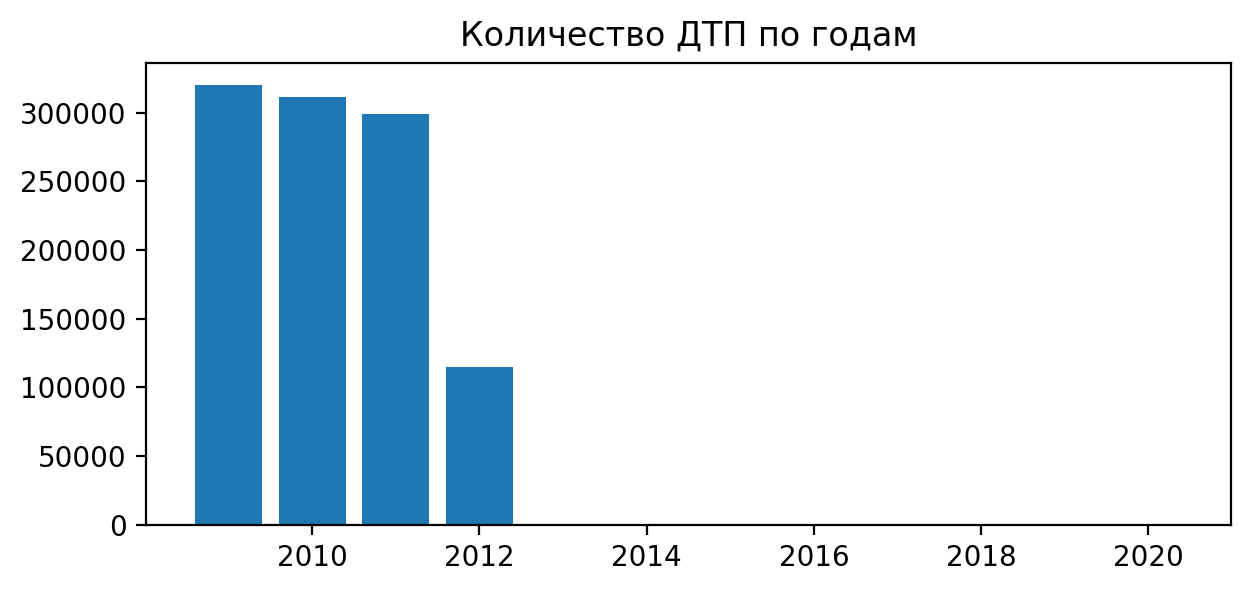

In [17]:
plt.figure(figsize=(7, 3))
plt.bar(_data.collision_year, _data.collisions_number)
plt.title("Количество ДТП по годам")
plt.show()

Мы видим, что в 2012 году количество ДТП уменьшилось в три раза и в последующие годы количество ДТП близко к нулю.

In [18]:
query = """
    SELECT 
        date_trunc('MONTH', c.collision_date)::date AS collision_month,
        count(DISTINCT(c.case_id)) AS collisions_number,
        MIN(EXTRACT('YEAR' FROM c.collision_date)) as year_number,
        MIN(EXTRACT('MONTH' FROM c.collision_date)) as month_number
    FROM parties p 
    JOIN collisions c ON p.case_id = c.case_id 
    WHERE p.party_type = 'car'
        AND c.collision_damage != 'scratch'
        AND c.collision_date BETWEEN '2009-01-01' AND '2012-12-31'
    GROUP BY date_trunc('MONTH', c.collision_date);
"""

_data = ds.exec_query(query)

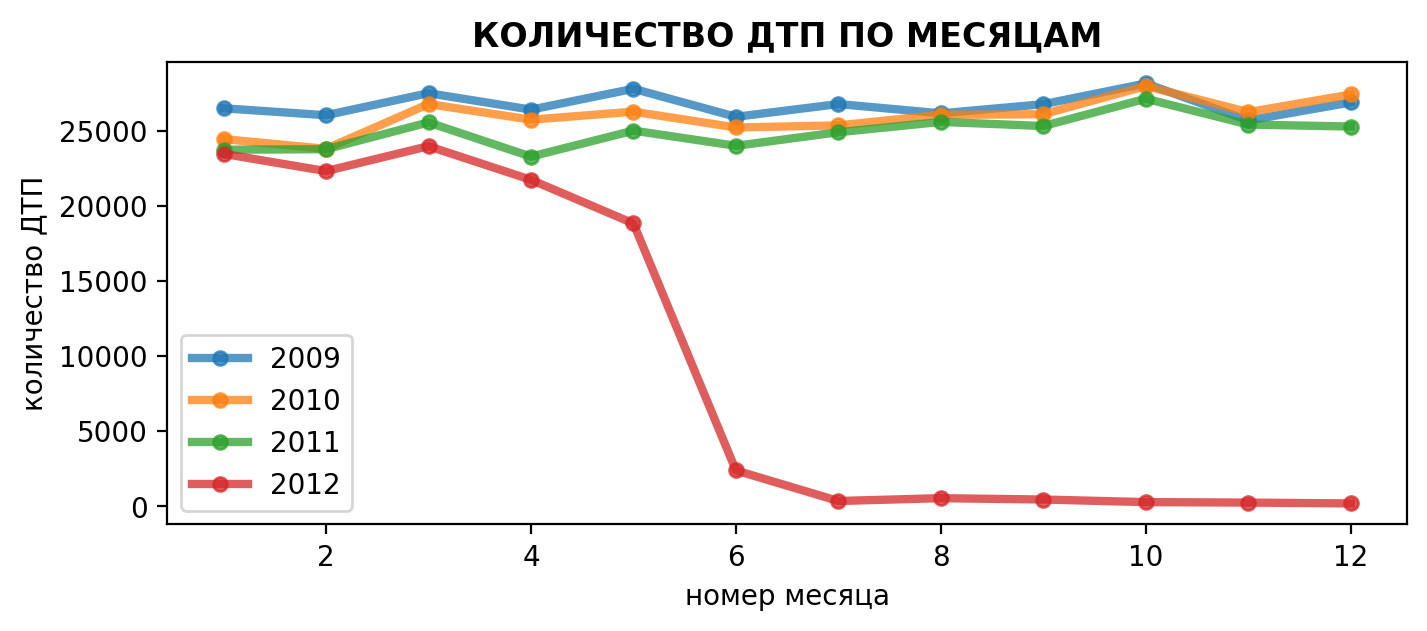

In [19]:
plt.figure(figsize=(8, 3))
for year in _data.year_number.unique():
    plt.plot(range(1, 13),
             _data[_data.year_number == year].collisions_number,
             lw=3,
             alpha=.75,
             marker="o",
             markersize=5,
             label=int(year))
plt.title("Количество ДТП по месяцам".upper(), fontweight="semibold")
plt.xlabel("номер месяца")
plt.ylabel("количество ДТП")
plt.legend(loc="lower left")
plt.show()

На этой диаграмме мы видим, что начиная с мая 2012 года количество ДТП в данных резко снижается. То есть 2012 год содержит неполные данные. 

ВЫВОД: самые свежие данные за полный год находятся в диапазоне 1 мая 2011 — 30 апреля 2012 года. 

### Аналитические задачи

Заказчик поставил задачу определить оценить возможность предсказания ДТП на основании исторических данных об авариях.

Предоставленные исторические данные содержат только случаи ДТП, то есть в исторических данных все поездки закончились ДТП и вероятность ДТП в них 100%.

Целевой признак в данных — виновность участника ДТП. Таким образом, на имеющихся данных мы не можем построить модель предсказания веротяности ДТП. Мы можем изучить возможность предсказывать вину участника ДТП. 

#### Количество виновных и не виновных в ДТП

Изучим, как распределено количество ДТП по количеству виноватых и не виновтаых в каждом происшествии  сторон. 

Для каждого ДТП посчитаем количество виноватых и не виноватых в нем участников, а потом посчитаем количество ДТП для каждой комбинации количества виноват-не виноват. 

In [20]:
query = """
    WITH fault_combinations AS 
        (SELECT 
            c.case_id, 
            sum(p.at_fault) AS at_fault_number, 
            count(p.id) - sum(p.at_fault) AS not_fault_number
        FROM parties p 
        JOIN collisions c ON p.case_id = c.case_id 
        WHERE c.collision_damage != 'scratch'
            AND c.collision_date BETWEEN '2009-05-01' AND '2012-04-30'
        GROUP BY c.case_id)
    SELECT 
        at_fault_number,
        not_fault_number,
        count(case_id) AS collisions_num
    FROM fault_combinations
    GROUP BY 
        at_fault_number,
        not_fault_number
    ORDER BY count(case_id) DESC;
"""
_data = ds.exec_query(query)

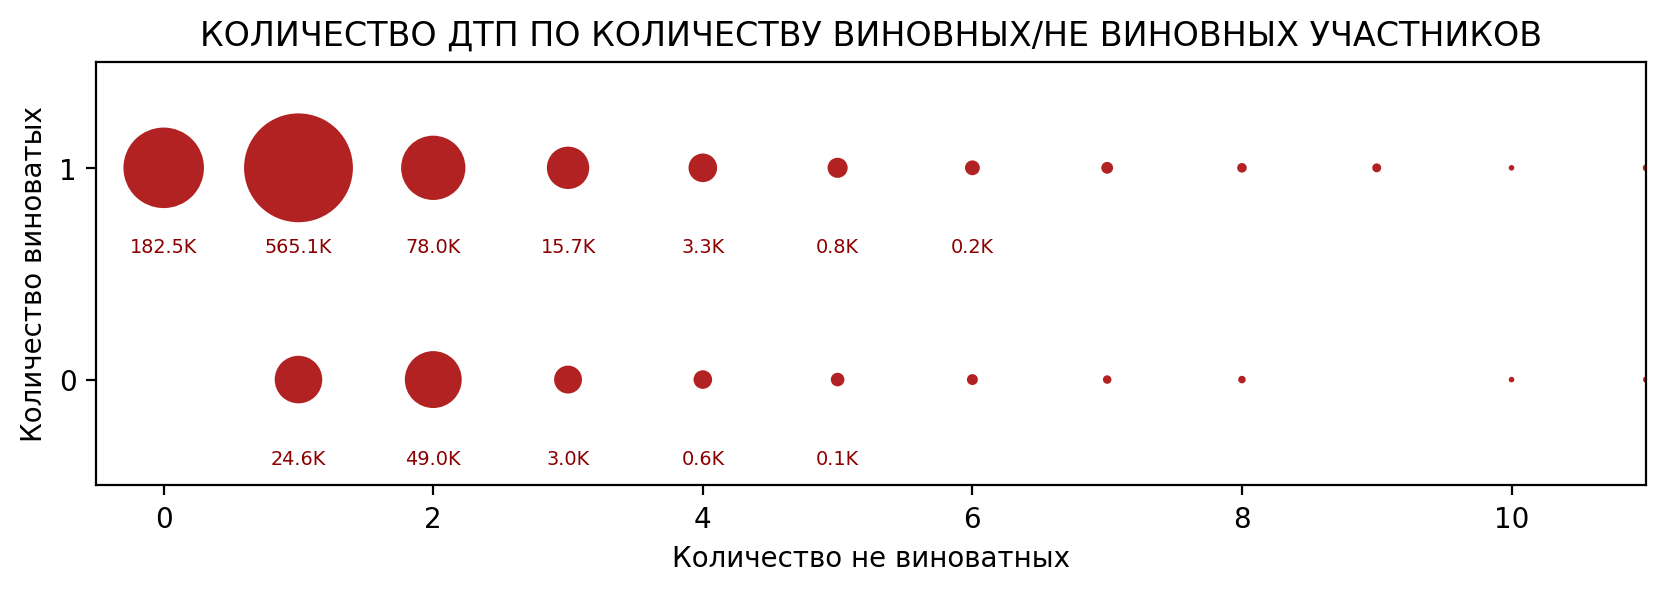

In [21]:
plt.figure(figsize=(10, 2.75))
plt.scatter(
    _data.not_fault_number,
    _data.at_fault_number,
    s=np.power(_data.collisions_num, .55),
    color="firebrick",
)
for i, r in _data.iterrows():
    if r["collisions_num"] < 1e2:
        continue
    plt.text(r["not_fault_number"],
             r["at_fault_number"] - .4,
             f'{r["collisions_num"]/1000:.1f}K',
             color="darkred",
             horizontalalignment="center",
             fontsize="x-small")

plt.yticks([0, 1])
plt.ylim(-.5, 1.5)
plt.xlim(-.5, 11)
plt.title(
    "Количество ДТП по количеству виновных/не виновных участников".upper())
plt.ylabel("Количество виноватых")
plt.xlabel("Количество не виноватных")
plt.show()

Мы видим, что в нашем датасете количество виноватых в происшествии не превышает 1 водителя. 

Самая распространная ситуация: ДТП с одним виновным и одним невиновным. Второе место по количеству ДТП занимают случаи, когда есть только виновный.

Около 75 тыс. зафиксированных случаев ДТП не имеют виновника.

**ВЫВОД**

Исходы только с невиновными участниками могут говорить о влиянии внешних факторов на ДТП. 

### Виновность и трезвость

Изучим, как соотносится Виновность участника AT_FAULT с Трезвость участника PARTY_SOBRIETY

Среди участников ДТП на автомобилях, для каждого значения трезовсти посчитаем количество учатсников, ставших винвниками ДТП и количество невиновных.

Рассчитаем [Aiffinity Index](https://medium.com/arocket/affinity-index-in-marketing-2badea3019c4) для каждого значения опьяния, приняв количество невиновых за общую группу, а количество виновных — за целевую. 

$ \mathit{AI} = \frac{\mathit{Target}}{\mathit{General}} \times 100\% $


In [22]:
query = """
    SELECT 
        p.party_sobriety,
        sum(p.at_fault) AS at_fault_number,
        count(p.id) - sum(p.at_fault) AS not_fault_number
    FROM parties p 
    JOIN collisions c ON p.case_id = c.case_id 
    WHERE p.party_type = 'car'
        AND c.collision_damage != 'scratch'
        AND c.collision_date BETWEEN '2009-04-01' AND '2012-05-01'
    GROUP BY p.party_sobriety;
"""
_data = ds.exec_query(query)

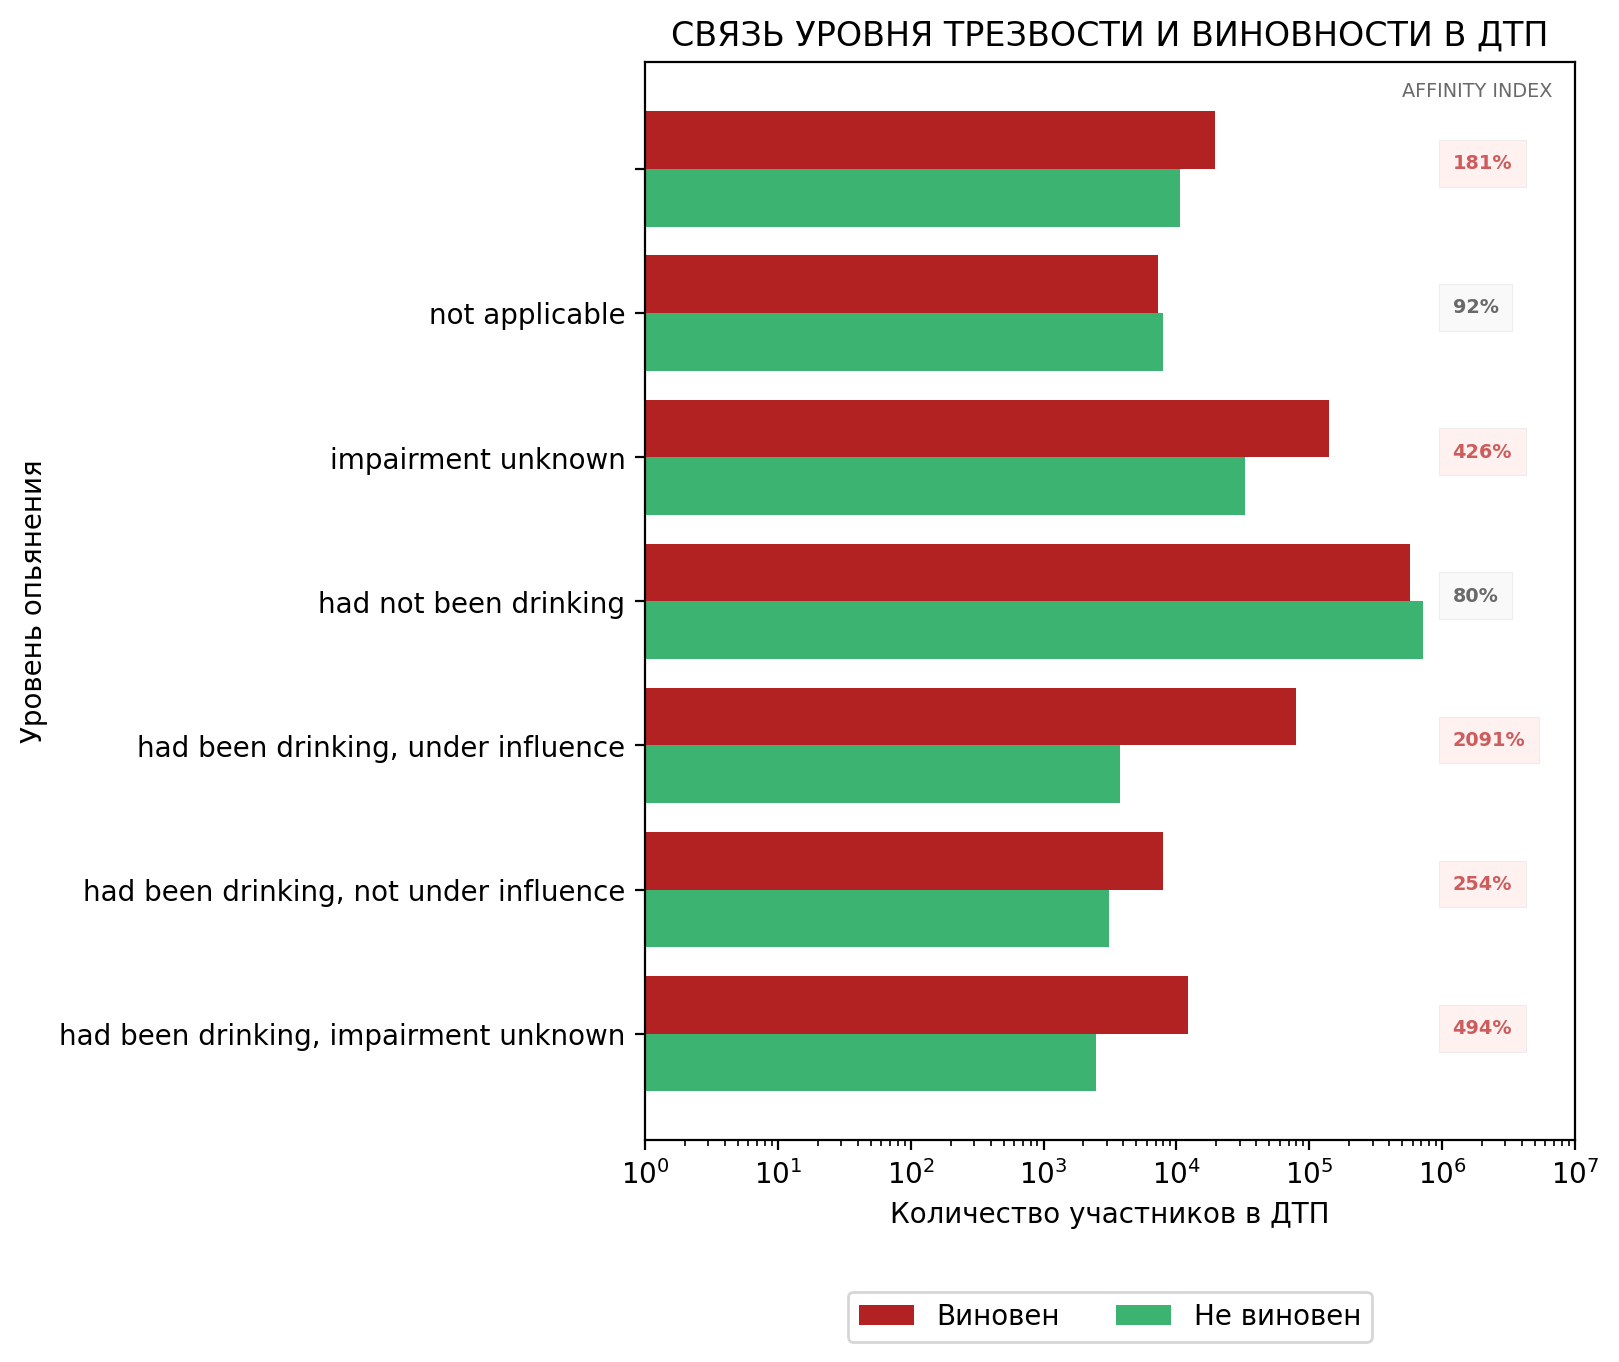

In [23]:
y = np.arange(0, _data.shape[0])
fig = plt.figure(figsize=(6, 7))
plt.barh(y + .2,
         width=_data.at_fault_number,
         height=.4,
         label="Виновен",
         color="firebrick")
plt.barh(y - .2,
         width=_data.not_fault_number,
         height=.4,
         label="Не виновен",
         color="mediumseagreen")

for i, r in _data.iterrows():
    ai = 100 * r["at_fault_number"] / r["not_fault_number"]
    if ai < 80 or ai > 120:
        facecolor = "mistyrose"
        fontcolor = "indianred"
    else:
        facecolor = "whitesmoke"
        fontcolor = "dimgrey"

    plt.text(1.2e6,
             i,
             f'{ai:.0f}%',
             fontsize="x-small",
             horizontalalignment="left",
             color=fontcolor,
             fontweight="bold",
             bbox={
                 'facecolor': facecolor,
                 'pad': 5,
                 'alpha': .5,
                 'edgecolor': 'lightgrey',
                 'lw': .25
             })
plt.yticks(y, _data.party_sobriety)
plt.ylabel("Уровень опьянения")
plt.xscale("log")
plt.xlim(1, 1e7)
plt.xlabel("Количество участников в ДТП")
plt.text(.5e6,
         6.5,
         "Affinity Index".upper(),
         fontsize="x-small",
         color="dimgrey")
plt.title("Связь уровня трезвости и виновности в ДТП".upper())
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

Создайте не менее шести задач, для решения должна использоваться связь не менее 2 таблиц, например
- Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
- Найдите самые частые причины ДТП (таблица parties).

Решим не менее двух задач самостоятельно

> Студент сам ставит аналитическую задачу. Как минимум должен записать шесть. А по 3-м из них создать запрос, построить график, сделать вывод

Поскольку у нас нет данных о поездках без аварий, мы не можем оценивать влияние на вероятность ДТП внешних условий: погода, локация, состояние дороги. Мы не знаем, как эти факторы влияют на интенсивность движения в целом. Изменение количества ДТП может быть связано с тем, например, что в плохую погоду, или в светлое время суток, люди больше или меньше ездят на автомобилях. Без информации об общем количестве поездок мы не можем делать вывод о влияние фактора на вероятность ДТП.

Поэтому сосредоточимся на факторах, относящихся к ДТП: 


1. Категория нарушения	PCF_VIOLATION_CATEGORY и Номер географических районов, где произошло ДТП	COUNTY_CITY_LOCATION
1. Основной фактор аварии	PRIMARY_COLL_FACTOR и Освещение	LIGHTING
1. Как соотносится Виновность участника	AT_FAULT с типом кузова Тип кузова	VEHICLE_TYPE
1. Как соотноится Виновность участника	AT_FAULT с Трезвость участника	PARTY_SOBRIETY
1. Как соотносится Виновность участника	AT_FAULT с Возраст автомобиля (в годах)	VEHICLE_AGE
1. Как соотносится Серьёзность происшествия	COLLISION_DAMAGE и Трезвость участника	PARTY_SOBRIETY



### Выводы

## Подготовка данных для моделирования

1. Подготовьте набор данных на основе первичного предположения заказчика:
- Выберите тип виновника — только машина (car). **
- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмите данные только за 2012 год.
- Подготовка исходной таблицы должна проводиться с помощью sql-запроса.

2. Проведите первичный отбор факторов, необходимых для модели.
- Изучите описание факторов. Нужно отобрать те, которые могут влиять на вероятность ДТП. Будет хорошо, если вы аргументируете свой выбор. Пример:

```
columms =['party_type',     # Тип участника происшествия. Таблица parties
          'party_sobriety', # Уровень трезвости виновника (точно может влиять) Таблица parties
           ......
         ] 
```

3. Проведите статистическое исследование отобранных факторов.
- По результату исследовательского анализа внесите корректировки, если они нужны. Сделайте вывод.
- Если необходимо, категоризируйте исходные данные, проведите масштабирование.
- Подготовьте обучающую и тестовую выборки.

Информация о повреждении автомобилей в ДТП находится в таблице `collisions`, где мы имеем одну запись на одно ДТП (`case_id`). Таким образом условие  "ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина)" в нашем датасете описывается условием `collisions.collision_damage != 'scratch'`.

Мы не можем предсказать вероятность ДТП, можем предсказывать только виновность в ДТП. Тогда для предсказания мы можем использовать факторы, относящиеся к виновнику происшествия и его автомобилю. Факторы, относящиеся к ДТП в целом являются общими, то есть действуют одновременно для всех участников. Поэтому мы не можем использовать их для оценки вероятности ДТП.

|Фактор |Значение |Гипотеза|
|---|---|---|
|`weather_1`|Погода||
|`road_surface`|Состояние дороги||
|`road_condition_1`|Дорожное состояние||
|`lighting`|Освещение||
|`control_device`|Устройство управления||
|`parties.insurance_premium` |Сумма страховки (тыс. $) |Водители с дорогой страховкой могут ощущать защиту и ездить небрежно  |
|`parties.party_sobriety` |Трезвость участника | мы видели, что трезвость связана с виновностью ДТП |
|`parties.cellphone_in_use` |Наличие телефона в автомобиле (возможности разговаривать по громкой связи) | использование телефона может влиять на виновность из-за невнимательного вождения|
|`vehicles.vehicle_type` |Тип кузова | спортивные или семенйные типы автомобиля могут отражать характер вождения влиять на виновность в ДТП  |
|`vehicles.vehicle_transmission` |Тип КПП | тип КПП может влиять на характер вождения и на виновность в ДТП|
|`vehicles.vehicle_age` |Возраст автомобиля (в годах) |Запрос от закзачика. Очень старые, как очень дешевые, автомобили могут покупаться людьми без опыта и влиять на виновность |

`parties.at_fault` — Целевой признак


Подготовим набор данных на основе первичного предположения заказчика:
- Тип виновника — только машина (car). 
- Анализируем случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмите данные только за 2012 год.

Дополнительные условия из статистического анализа данных: 
- период -- последний полный год данных: 1 мая 2011 по 30 апреля 2012,
- в зафиксированном случае ДТП должно быть не менее двух машин с известными характеристиками автомобилей и не менее одного виновного;
- уровень опьянения водителя должен быть указан;
- возраст автомобиля должен быть указан.

### Загрузка данных

In [24]:
START_DAY, END_DAY = "2011-05-01", "2012-04-30"

In [25]:
query = f"""
SELECT 
    c.weather_1,
    c.road_surface,
    c.road_condition_1,
    c.lighting,
    c.control_device,
    p.insurance_premium,
    p.party_sobriety,
    p.cellphone_in_use,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age,
    p.at_fault 
FROM collisions c
    JOIN parties p ON c.case_id = p.case_id 
    JOIN vehicles v ON v.case_id = p.case_id AND v.party_number = p.party_number 
WHERE 
    c.collision_date BETWEEN '{START_DAY}' AND '{END_DAY}'
    AND c.collision_damage != 'scratch'
    AND p.party_type = 'car'
    AND v.vehicle_age IS NOT NULL
ORDER BY c.case_id ;
"""

In [26]:
query = f"""
WITH filtered_data
AS (SELECT
    c.case_id,
    p.id AS party_id,
    v.id AS vehical_id,
    COUNT(p.id) OVER (PARTITION BY c.case_id) AS cars_parties_num,
    SUM(p.at_fault) OVER (PARTITION BY c.case_id) AS at_fault_num,
    c.weather_1,
    c.road_surface,
    c.road_condition_1,
    c.lighting,
    c.control_device,
    p.insurance_premium,
    p.party_sobriety,
    p.cellphone_in_use,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age,
    p.at_fault
FROM collisions c
INNER JOIN parties p
    ON c.case_id = p.case_id
INNER JOIN vehicles v
    ON p.case_id = v.case_id
    AND p.party_number = v.party_number
WHERE c.collision_damage != 'scratch'
AND p.party_type = 'car'
AND collision_date BETWEEN '2011-05-01' AND '2012-04-30')
SELECT
    weather_1,
    road_surface,
    road_condition_1,
    lighting,
    control_device,
    insurance_premium,
    party_sobriety,
    cellphone_in_use,
    vehicle_type,
    vehicle_transmission,
    vehicle_age,
    at_fault
FROM filtered_data
WHERE (cars_parties_num = 1
AND at_fault_num = 1)
OR at_fault_num = 0;
"""

In [27]:
df = ds.exec_query(query)
df.shape

(94816, 12)

Мы загрузили 46 199 строк и 9 признаков, включая целевой.

### Анализ данных

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94816 entries, 0 to 94815
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weather_1             94484 non-null  object 
 1   road_surface          94255 non-null  object 
 2   road_condition_1      94335 non-null  object 
 3   lighting              94463 non-null  object 
 4   control_device        94413 non-null  object 
 5   insurance_premium     93652 non-null  float64
 6   party_sobriety        93140 non-null  object 
 7   cellphone_in_use      86752 non-null  float64
 8   vehicle_type          94816 non-null  object 
 9   vehicle_transmission  93244 non-null  object 
 10  vehicle_age           91783 non-null  float64
 11  at_fault              94816 non-null  int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 8.7+ MB


In [29]:
df.isna().sum()

weather_1                332
road_surface             561
road_condition_1         481
lighting                 353
control_device           403
insurance_premium       1164
party_sobriety          1676
cellphone_in_use        8064
vehicle_type               0
vehicle_transmission    1572
vehicle_age             3033
at_fault                   0
dtype: int64

In [30]:
df[["insurance_premium", "vehicle_age"]].describe()

,insurance_premium,vehicle_age
count,93652.000000,91783.000000
mean,37.155576,4.729917
std,16.190282,3.057777
min,0.000000,0.000000
25%,23.000000,3.000000
50%,34.000000,4.000000
75%,48.000000,7.000000
max,105.000000,19.000000


Макс. возраст авто 161

array([[<AxesSubplot: title={'center': 'insurance_premium'}>,
        <AxesSubplot: title={'center': 'vehicle_age'}>]], dtype=object)

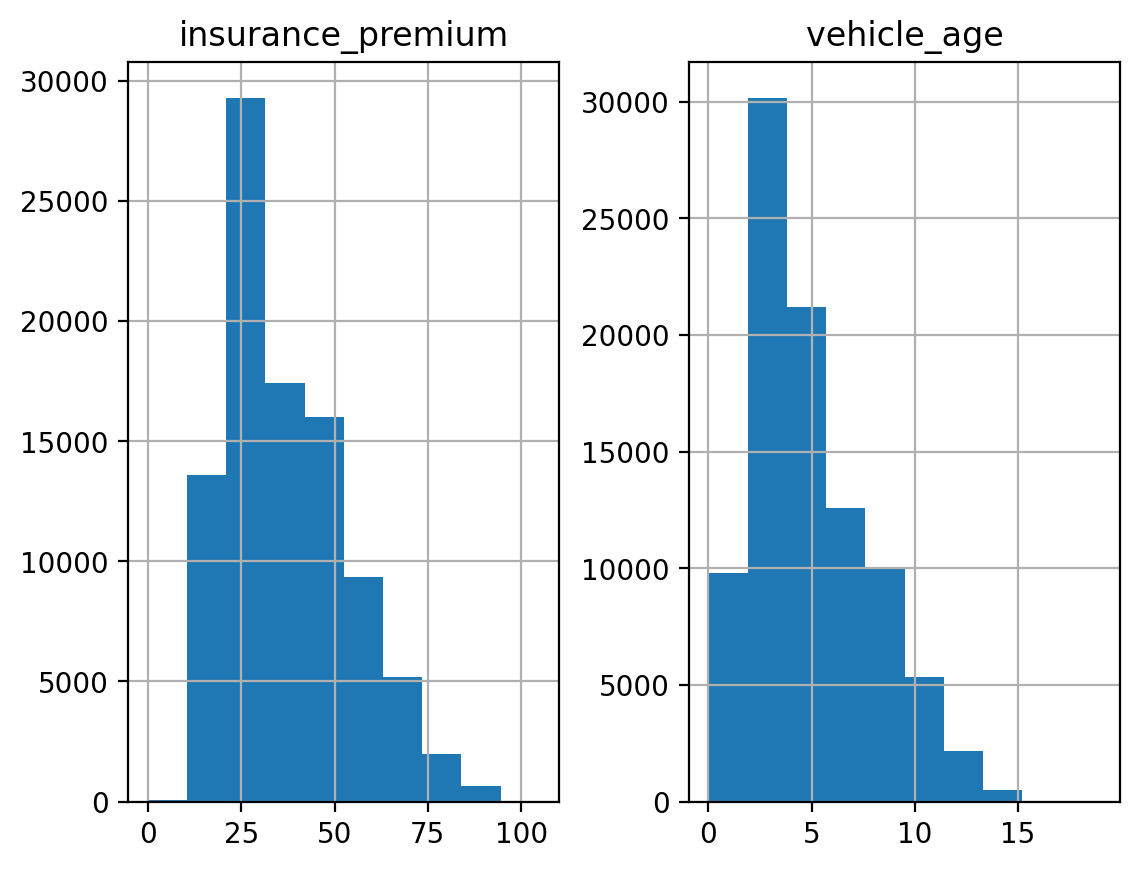

In [31]:
df[["insurance_premium", "vehicle_age"]].hist()

<AxesSubplot: >

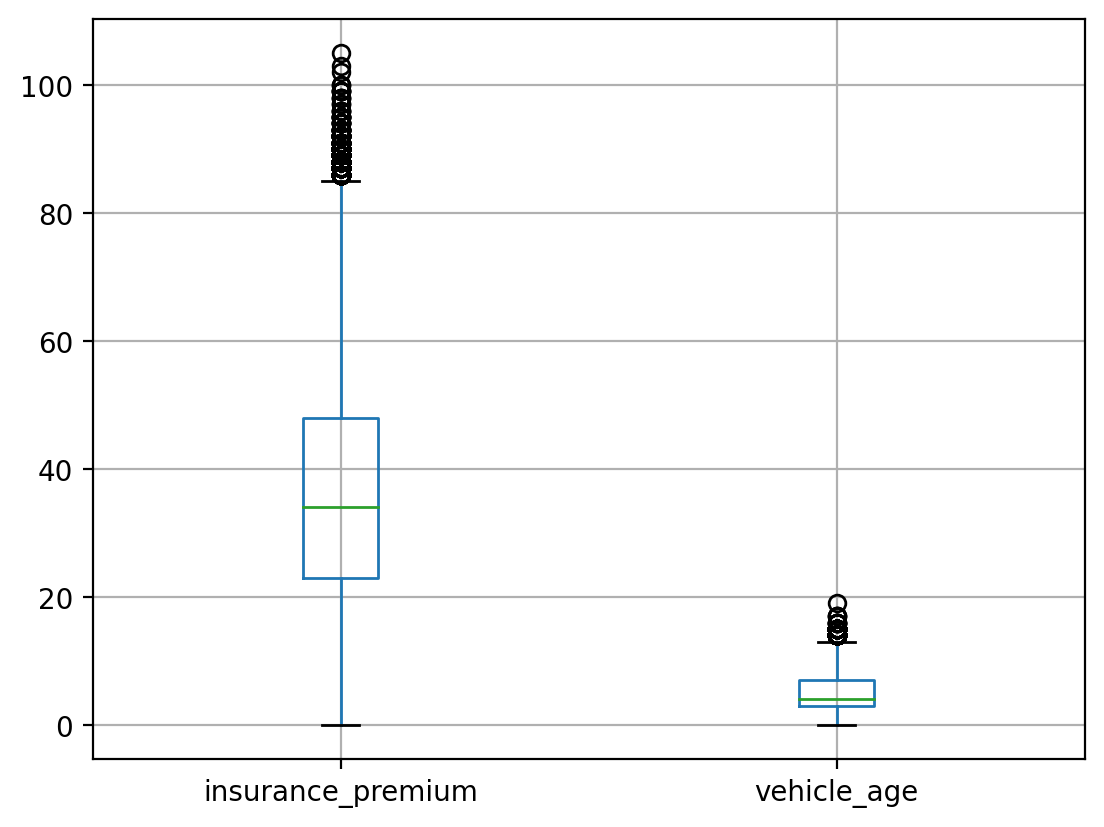

In [32]:
df[["insurance_premium", "vehicle_age"]].boxplot()

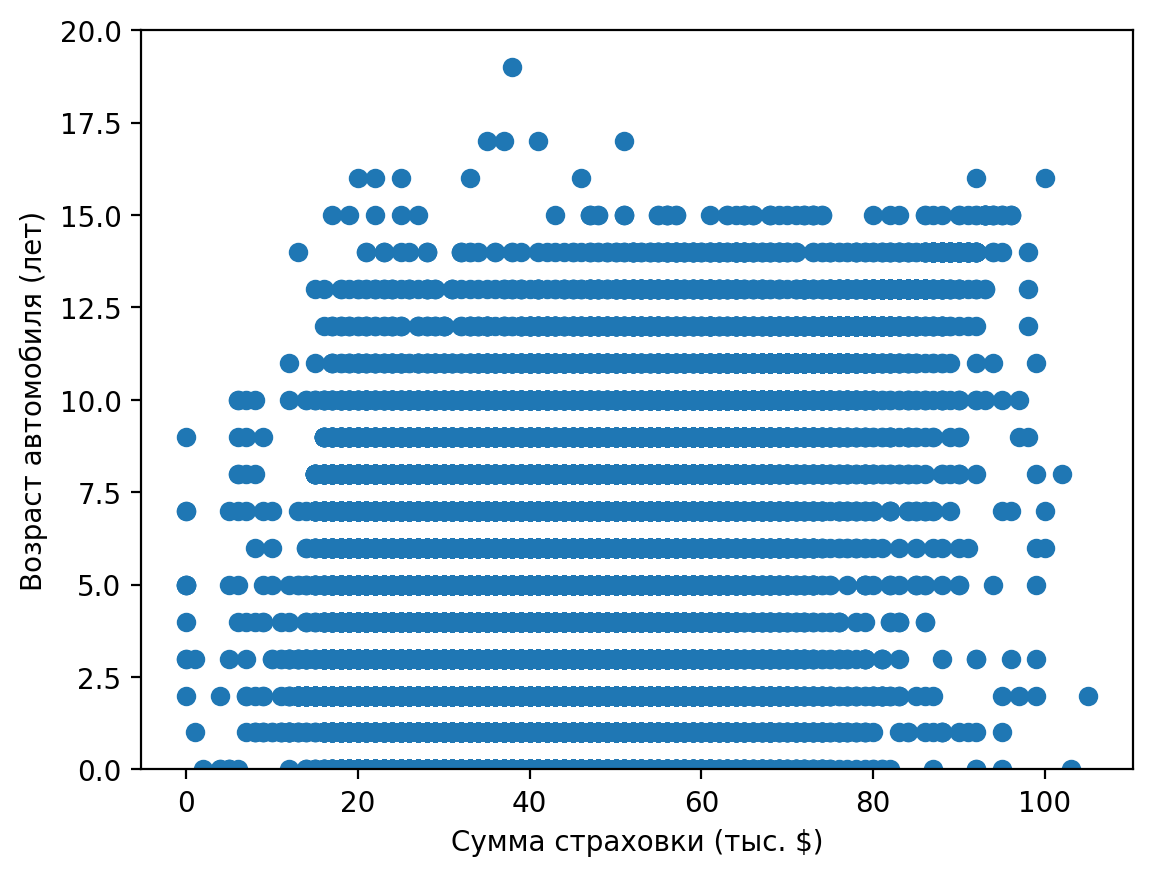

In [33]:
plt.scatter(df.insurance_premium, df.vehicle_age)
plt.ylim(0,20)
plt.xlabel("Сумма страховки (тыс. $)")
plt.ylabel("Возраст автомобиля (лет)")
plt.show()

In [34]:
target = "at_fault"
numerical_features = ["insurance_premium", "vehicle_age"]
categorical_features = [_ for _ in df.columns if _ not in numerical_features]
categorical_features.remove(target)

In [35]:
categorical_features

['weather_1',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'party_sobriety',
 'cellphone_in_use',
 'vehicle_type',
 'vehicle_transmission']

In [36]:
for col in categorical_features:
    print(col)
    print(df[col].value_counts())
    print()

weather_1
clear      78659
cloudy     12357
raining     2797
fog          407
snowing      170
other         73
wind          21
Name: weather_1, dtype: int64

road_surface
dry         86606
wet          7063
snowy         491
slippery       95
Name: road_surface, dtype: int64

road_condition_1
normal            91058
construction       1704
obstruction         438
other               365
holes               329
loose material      291
reduced width       103
flooded              47
Name: road_condition_1, dtype: int64

lighting
daylight                                   62586
dark with street lights                    19157
dark with no street lights                  9399
dusk or dawn                                3041
dark with street lights not functioning      280
Name: lighting, dtype: int64

control_device
none               66823
functioning        27326
not functioning      219
obscured              45
Name: control_device, dtype: int64

party_sobriety
had not been drinking   

In [37]:
df.at_fault.mean()

0.5094920688491393

### Исправление данных

Дополним критерии для выборки
- возраст автомобиля не более 20 лет,
- тип автомобиля не other
- сумма страховки заполнена

In [38]:
df = df[df.vehicle_age < 20]
df.shape

(91783, 12)

Проверим на дубликаты

In [39]:
df.duplicated().sum()

53791

In [40]:
df = df.drop_duplicates()

In [41]:
df.shape

(37992, 12)

### Разделение выборок

In [42]:
X = df.drop("at_fault", axis=1)
y = df.at_fault

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=RANDOM_STATE)
print("Train shape", X_train.shape, y_train.shape)
print("Test shape", X_test.shape, y_test.shape)

Train shape (30393, 11) (30393,)
Test shape (7599, 11) (7599,)


### Преобразование данных

#### Заполнение пропусков

In [44]:
categorical_features_num = ["cellphone_in_use"]
categorical_features_str = [
    _ for _ in categorical_features if _ not in categorical_features_num
]
categorical_features_str

['weather_1',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'party_sobriety',
 'vehicle_type',
 'vehicle_transmission']

Заменим пропуски в строковых категориальных признаках на константу 'unknown', в числовом категориальном признаке `cellphone_in_use` на 2.

In [45]:
categorical_str_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value="unknown")), 
           ("encoder", OrdinalEncoder(dtype=int, handle_unknown="error")),
           ("scaler", MinMaxScaler())]
)
categorical_num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value=2)), 
          ("scaler", MinMaxScaler())]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical_str", categorical_str_transformer, categorical_features_str),
        ("categorical_num", categorical_num_transformer, categorical_features_num),
        ("numerical", numeric_transformer, numerical_features)
    ]
)

In [47]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [48]:
X_train.shape, X_test.shape

((30393, 11), (7599, 11))

In [49]:
X_train_preprocessed.shape, X_test_preprocessed.shape

((30393, 11), (7599, 11))

In [50]:
pd.DataFrame(X_train_preprocessed,
             columns=categorical_features_str + categorical_features_num +
             numerical_features).head()

,weather_1,road_surface,road_condition_1,lighting,control_device,party_sobriety,vehicle_type,vehicle_transmission,cellphone_in_use,insurance_premium,vehicle_age
0,0.000000,0.00,0.0,0.2,0.25,0.5,1.0,0.0,0.0,0.514286,0.157895
1,0.000000,0.00,0.5,0.6,0.00,0.5,1.0,0.5,0.0,0.676190,0.631579
2,0.000000,0.00,0.5,0.2,0.00,0.5,1.0,0.5,0.0,0.333333,0.000000
3,0.571429,0.75,0.5,0.6,0.25,0.5,1.0,0.0,0.0,0.495238,0.105263
4,0.000000,0.00,0.5,0.6,0.25,0.5,1.0,0.5,0.5,0.580952,0.578947


#### Без заполнения пропусков

Алгоритм  HistGradientBoostingClassifier поддерживает обработку пропущенных значений. Для него подготовим датасет, в котором оставим пропуски незаполненными. Выполним кодирование категориальных признаков и масштабирование числовых.

In [76]:
preprocessor_na = ColumnTransformer(
    transformers=[
        ("categorical_str", OrdinalEncoder(dtype=float, handle_unknown="error"), categorical_features_str),
        ("categorical_num", 'passthrough', categorical_features_num),
        ("numerical", MinMaxScaler(), numerical_features)
    ]
)

In [77]:
X_train_preprocessed_na = preprocessor_na.fit_transform(X_train)
X_test_preprocessed_na = preprocessor_na.transform(X_test)

In [78]:
pd.DataFrame(X_train_preprocessed,
             columns=categorical_features_str + categorical_features_num +
             numerical_features).head()

,weather_1,road_surface,road_condition_1,lighting,control_device,party_sobriety,vehicle_type,vehicle_transmission,cellphone_in_use,insurance_premium,vehicle_age
0,0.000000,0.00,0.0,0.2,0.25,0.5,1.0,0.0,0.0,0.514286,0.157895
1,0.000000,0.00,0.5,0.6,0.00,0.5,1.0,0.5,0.0,0.676190,0.631579
2,0.000000,0.00,0.5,0.2,0.00,0.5,1.0,0.5,0.0,0.333333,0.000000
3,0.571429,0.75,0.5,0.6,0.25,0.5,1.0,0.0,0.0,0.495238,0.105263
4,0.000000,0.00,0.5,0.6,0.25,0.5,1.0,0.5,0.5,0.580952,0.578947


## Модели оценки водительского риска

### Базовые модели

Создадим пайплайны для обучения

In [51]:
categorical_mask = [True] * len(categorical_features) + [False] * len(
    numerical_features)

In [52]:
classifiers = [
    DummyClassifier(),
    LogisticRegression(random_state=RANDOM_STATE),
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    HistGradientBoostingClassifier(random_state=RANDOM_STATE,
                                   categorical_features=categorical_mask)
]

In [53]:
pipelines = [
    Pipeline([
        ('preprocessor', preprocessor),
        ('estimator', _)
    ])
    for _ in classifiers
]

Для оценки результатов будем использовать CV

In [54]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)

In [82]:
for clf in classifiers:
    if "HistGradient" in str(clf):
        cross_validate_model(estimator=clf,
                             X=X_train_preprocessed_na,
                             y=y_train,
                             cv=cv)
    else:
        cross_validate_model(estimator=clf,
                             X=X_train_preprocessed,
                             y=y_train,
                             cv=cv)


DummyClassifier()
fit time	 0.01s +/- 0.01s
score time	 0.00s +/- 0.00s
Accuracy	 0.54 +/- 0.01
ROC AUC 	 0.50 +/- 0.00


LogisticRegression(random_state=RandomState(MT19937) at 0x132FA8D40)
fit time	 0.09s +/- 0.02s
score time	 0.01s +/- 0.01s
Accuracy	 0.61 +/- 0.01
ROC AUC 	 0.64 +/- 0.01


DecisionTreeClassifier(max_depth=150, min_samples_leaf=64,
                       min_samples_split=1024,
                       random_state=RandomState(MT19937) at 0x132FA8D40)
fit time	 0.05s +/- 0.02s
score time	 0.01s +/- 0.01s
Accuracy	 0.65 +/- 0.01
ROC AUC 	 0.71 +/- 0.01


HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                     True, True, True, True,
                                                     True, False, False],
                               random_state=RandomState(MT19937) at 0x132FA8D40)
fit time	 0.86s +/- 0.16s
score time	 0.23s +/- 0.05s
Accuracy	 0.66 +/- 0.01
ROC AUC 	 0.72 +/- 0.00



### Подбор гиперпараметров

In [89]:
lr_param_distributions = {
    'solver': ["newton-cg", "liblinear", "lbfgs", "sag", "saga"],
    'max_iter': np.arange(50, 600, 50),
    'C': np.logspace(-2, 1, num=10, endpoint=True, base=10, dtype=float, axis=0)
}

In [90]:
%%time
lr_search_estimator = RandomizedSearchCV(
    estimator=classifiers[1],
    param_distributions=lr_param_distributions,
    n_iter=50,
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)
lr_search_estimator.fit(X_train_preprocessed, y_train)

Fitting 25 folds for each of 50 candidates, totalling 1250 fits
CPU times: user 1.91 s, sys: 313 ms, total: 2.22 s
Wall time: 36.7 s


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5,
       random_state=RandomState(MT19937) at 0x132FA8D40),
                   estimator=LogisticRegression(random_state=RandomState(MT19937) at 0x132FA8D40),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ]),
                                        'max_iter': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]),
                                        'solver': ['newton-cg', 'liblinear',
                                                   'lbfgs', 'sag', 'saga']},
                   random_state=RandomState(MT19937) at 0x132FA8D40,
                   refit=False, return_train_score=True, verbose=1)

In [91]:
dt_param_distributions = {
    'max_depth': np.arange(50, 510, 50),
    'min_samples_split': [2**i for i in range(6, 13)],
    'min_samples_leaf': [2**i for i in range(5, 11)]
}

In [92]:
%%time
dt_search_estimator = RandomizedSearchCV(
    estimator=classifiers[2],
    param_distributions=dt_param_distributions,
    n_iter=50,
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)
dt_search_estimator.fit(X_train_preprocessed, y_train)

Fitting 25 folds for each of 50 candidates, totalling 1250 fits
CPU times: user 1.9 s, sys: 262 ms, total: 2.16 s
Wall time: 15 s


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5,
       random_state=RandomState(MT19937) at 0x132FA8D40),
                   estimator=DecisionTreeClassifier(max_depth=150,
                                                    min_samples_leaf=64,
                                                    min_samples_split=1024,
                                                    random_state=RandomState(MT19937) at 0x132FA8D40),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]),
                                        'min_samples_leaf': [32, 64, 128, 256,
                                                             512, 1024],
                                        'min_samples_split': [64, 128, 256, 512,
                                                              1024, 2048,
                                                              4096]},
                   random_state=RandomState(MT19937) at 0x132FA8D40,
                   refit=False, return_train_score=True, verbose=1)

In [93]:
hgb_param_distributions = {
    'max_iter':
        np.arange(100, 1100, 200),
    'max_leaf_nodes': [2**i for i in range(8, 11)],
    'learning_rate':
        np.logspace(-2, 1, num=10, endpoint=True, base=10, dtype=float, axis=0),
    'min_samples_leaf': [2**i for i in range(10, 15)],
    'l2_regularization':
        np.append([0],
                  np.logspace(-1,
                              .25,
                              num=10,
                              endpoint=True,
                              base=10,
                              dtype=float,
                              axis=0))
}

In [94]:
%%time
try:
    with open('./data/hgb_search_results11.pkl', "rb") as file:
        hgb_search_estimator = pickle.load(file)  
except Exception:
    hgb_search_estimator = RandomizedSearchCV(
        estimator=classifiers[3],
        param_distributions=hgb_param_distributions,
        n_iter=100,
        n_jobs=-1,
        refit=False,
        cv=cv,
        verbose=1,
        random_state=RANDOM_STATE,
        return_train_score=True)    
    hgb_search_estimator.fit(X_train_preprocessed_na, y_train)
    with open('./data/hgb_search_results.pkl', "wb") as file:
        pickle.dump(hgb_search_estimator, file)    

Fitting 25 folds for each of 100 candidates, totalling 2500 fits
CPU times: user 5.95 s, sys: 843 ms, total: 6.79 s
Wall time: 11min 9s


### Анализ моделей

In [95]:
results_columns = [
    'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
    'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score',
    'params', 'rank_test_score'
]

In [98]:
lr_results = pd.DataFrame(
    lr_search_estimator.cv_results_)[results_columns].query(
        'mean_test_score > .6').sort_values(by="mean_test_score")

dt_results = pd.DataFrame(
    dt_search_estimator.cv_results_)[results_columns].query(
        'mean_test_score > .6').sort_values(
        by="mean_test_score")

hgb_results = pd.DataFrame(
    hgb_search_estimator.cv_results_)[results_columns].query(
        'mean_test_score > .6').sort_values(
        by="mean_test_score")

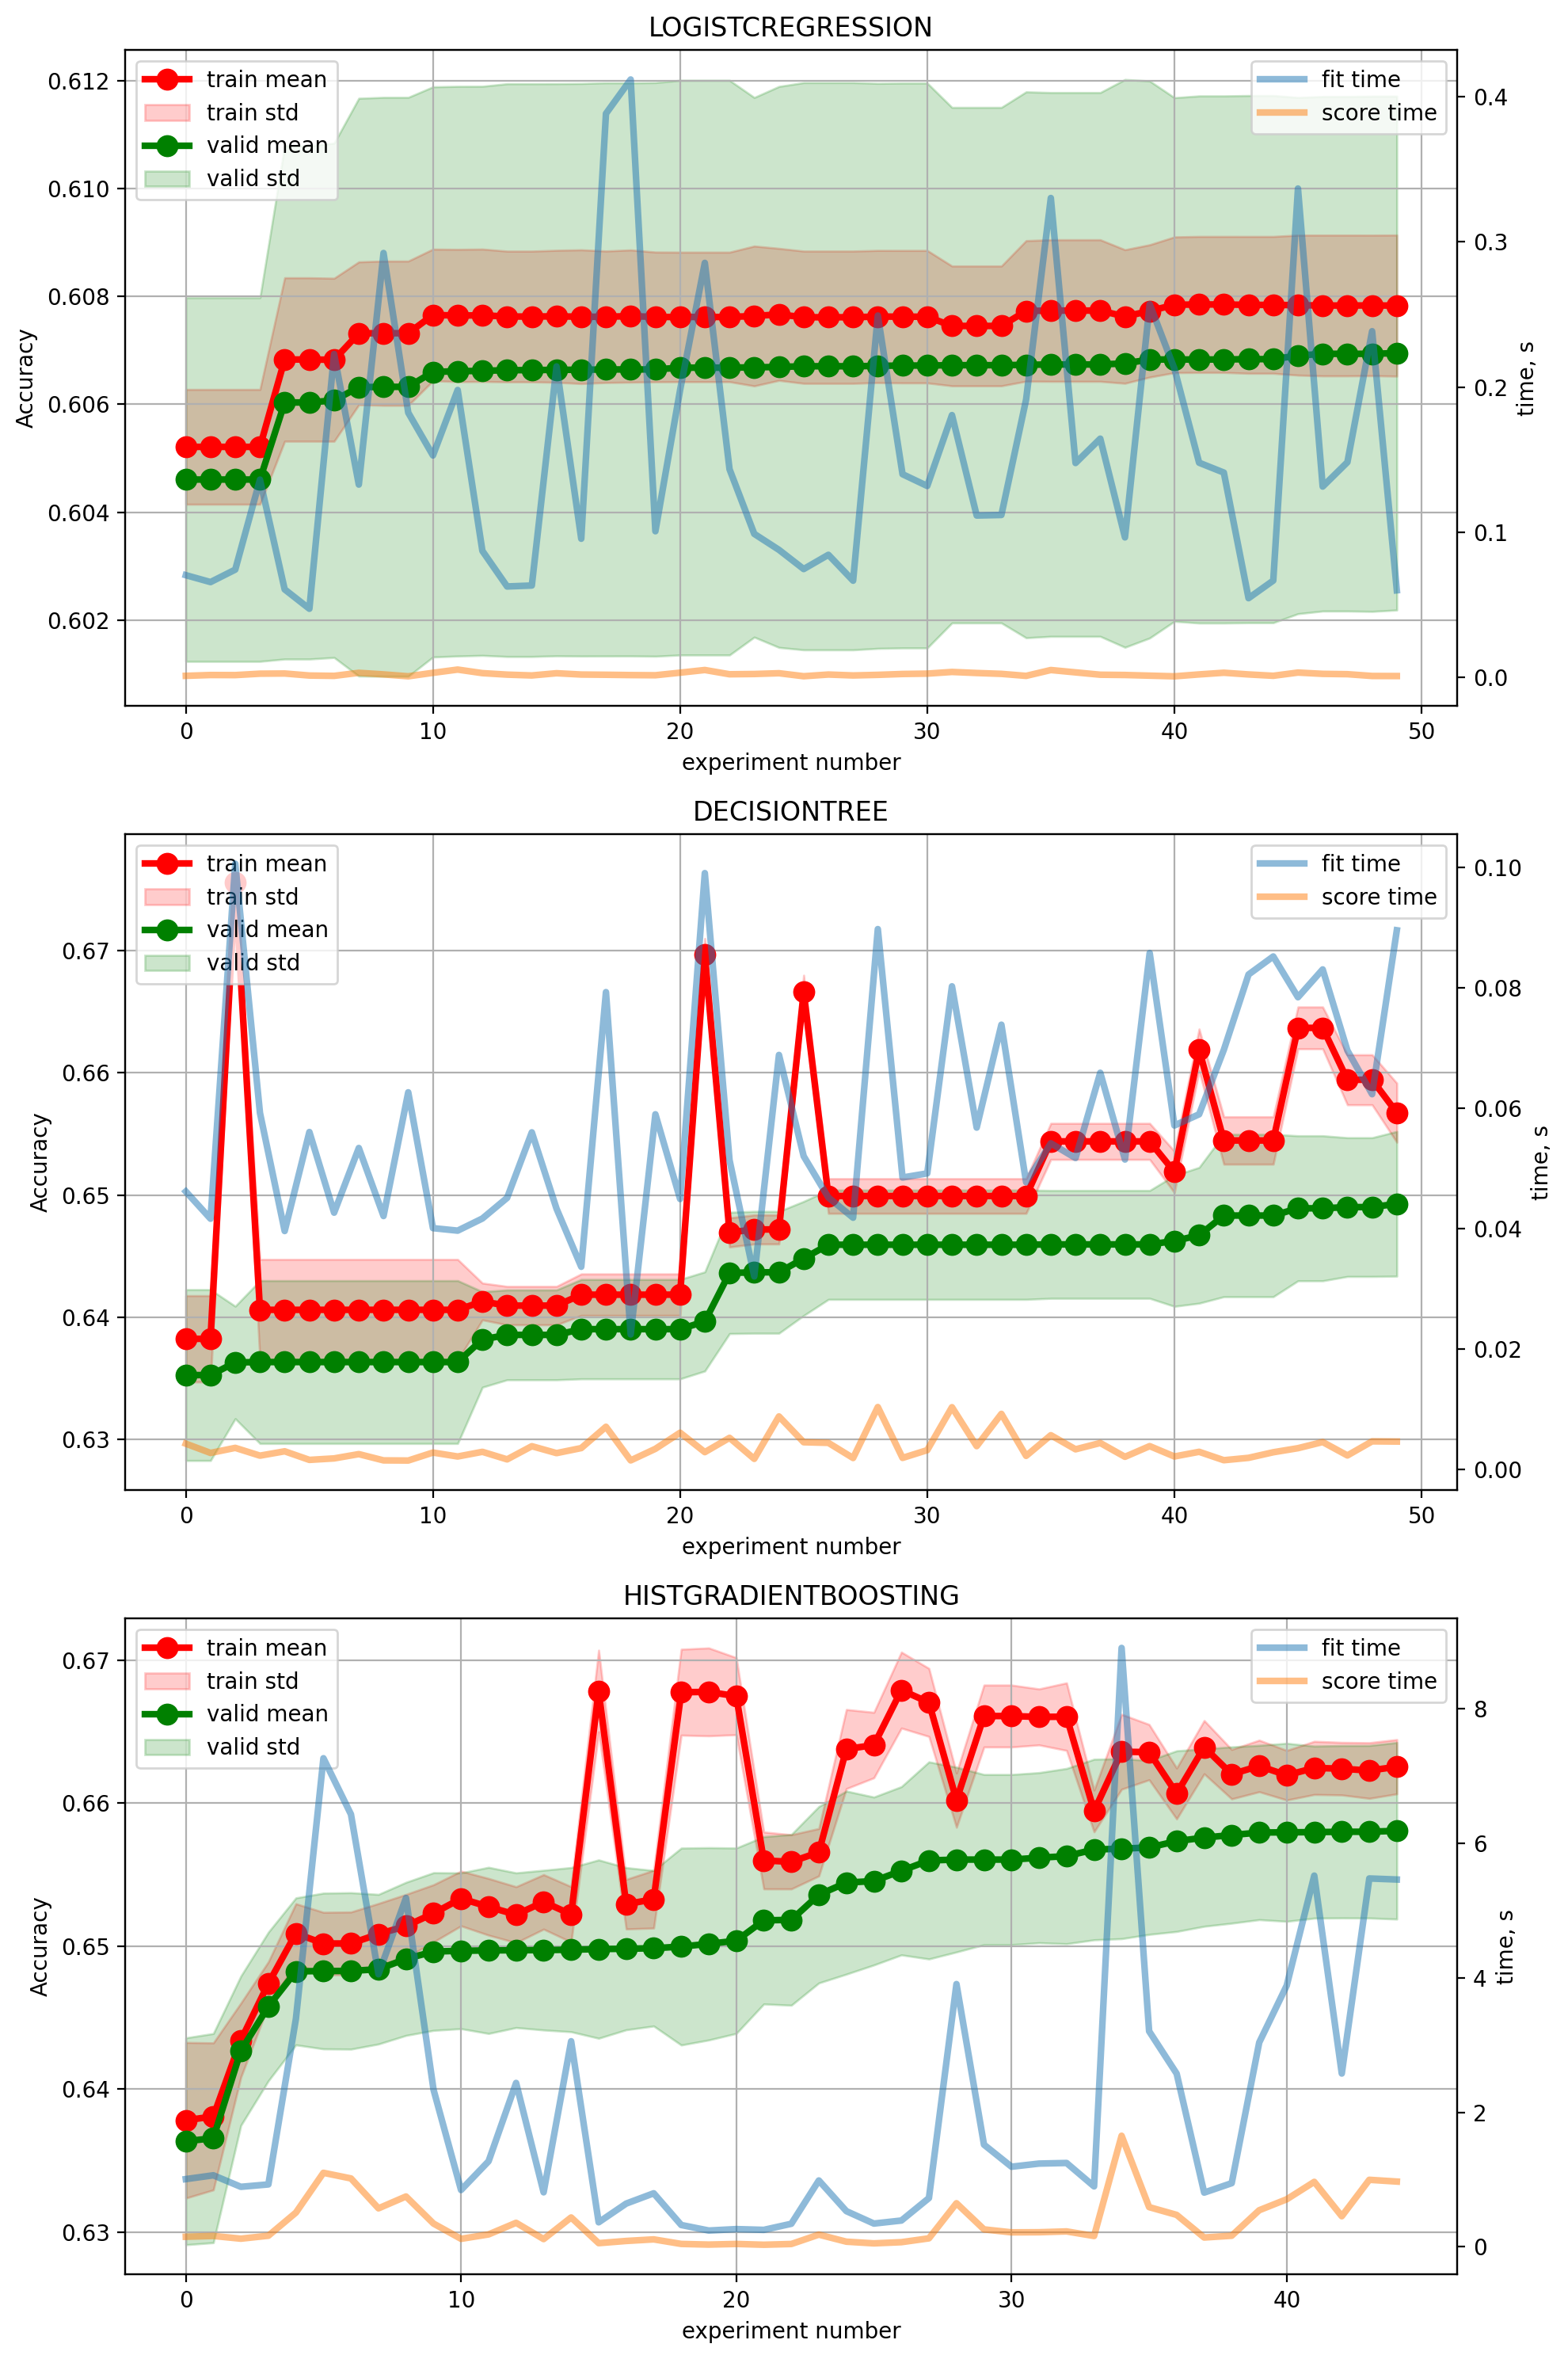

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
plot_searh_curve(lr_results, ax=ax1, model_name='LogistcRegression')
plot_searh_curve(dt_results, ax=ax2, model_name='DecisionTree')
plot_searh_curve(hgb_results, ax=ax3, model_name='HistGradientBoosting')
plt.tight_layout()
plt.show()

In [100]:
lr_best_idx = -1
dt_best_idx = -1
hgb_best_index = -1

_cols = hgb_results.columns.to_list()
_cols.remove('params')
_cols.remove('rank_test_score')

lr_best_params = lr_results.iloc[[lr_best_idx]].params.values[0]
dt_best_params = dt_results.iloc[[dt_best_idx]].params.values[0]
hgb_best_params = hgb_results.iloc[[hgb_best_index]].params.values[0]

comparison = pd.concat([
    lr_results.iloc[[lr_best_idx]],
    dt_results.iloc[[dt_best_idx]],
    hgb_results.iloc[[hgb_best_index]]
])[_cols].T
comparison.columns = ["LogisticRegression", "DecisionTree", "HistGradientBoosting"]

comparison

,LogisticRegression,DecisionTree,HistGradientBoosting
mean_fit_time,0.060140,0.089549,5.464208
std_fit_time,0.019852,0.026115,1.423974
mean_score_time,0.001107,0.004612,0.971864
std_score_time,0.000416,0.007996,0.256682
mean_test_score,0.606949,0.649281,0.658072
std_test_score,0.004761,0.005922,0.006180
mean_train_score,0.607829,0.656738,0.662559
std_train_score,0.001308,0.002418,0.001900


Лучшие параметры

In [101]:
lr_best_params

{'solver': 'lbfgs', 'max_iter': 250, 'C': 0.046415888336127774}

In [102]:
dt_best_params

{'min_samples_split': 1024, 'min_samples_leaf': 32, 'max_depth': 250}

In [103]:
hgb_best_params

{'min_samples_leaf': 2048,
 'max_leaf_nodes': 1024,
 'max_iter': 900,
 'learning_rate': 0.021544346900318832,
 'l2_regularization': 0.1895735652406376}

1. Смоделируйте не менее 3-х типов моделей с перебором гиперпараметров.
    1. 1–2 модели из числа линейные модели, деревья и леса;
    1. 1–2 модели из числа градиентных бустингов;
1. Выберите метрику для оценки модели, исходя из поставленной бизнесом задачи. Обоснуйте свой выбор.
1. Оформите вывод в виде сравнительной таблицы.

## Анализ важности факторов ДТП

1. Проведите графический анализ «Матрица ошибок». Выведите полноту и точность на график.
1. Проанализируйте важность основных факторов, влияющих на вероятность ДТП.
1. Для одного из выявленных важных факторов проведите дополнительное исследование:
- Покажите график зависимости фактора и целевой переменной.
- Предложите, чем можно оборудовать автомобиль, чтобы учесть этот фактор во время посадки водителя.


Пример решения задачи 3:

Выявили, что самый важный фактор ДТП — уровень трезвости виновника party_sobriety. Из таблицы исходных данных известно: есть несколько уровней трезвости. Тогда решение по пунктам выглядит так:
- Для графического анализа будем использовать столбчатую диаграмму. В ней отразим зависимость числа ДТП от уровня трезвости. Проанализируем график, сделаем выводы.
- Предложить оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место.

In [109]:
classifiers[3].set_params(**hgb_best_params)
classifiers[3].fit(X_train_preprocessed_na, y_train)

y_proba = classifiers[3].predict_proba(X_test_preprocessed_na)
y_pred = classifiers[3].predict(X_test_preprocessed_na)

In [111]:
print(classification_report(y_test, y_pred, target_names=["не виновен", "виновен"]))

              precision    recall  f1-score   support

  не виновен       0.61      0.71      0.66      3531
     виновен       0.71      0.61      0.65      4068

    accuracy                           0.66      7599
   macro avg       0.66      0.66      0.66      7599
weighted avg       0.66      0.66      0.66      7599



In [112]:
confusion_matrix(y_test, y_pred)

array([[2504, 1027],
       [1588, 2480]])

### SHAP

In [113]:
observations = pd.DataFrame(X_train_preprocessed_na,
    columns = categorical_features + numerical_features
)

In [114]:
explainer = shap.TreeExplainer(classifiers[3])

In [115]:
shap_values = explainer.shap_values(observations)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


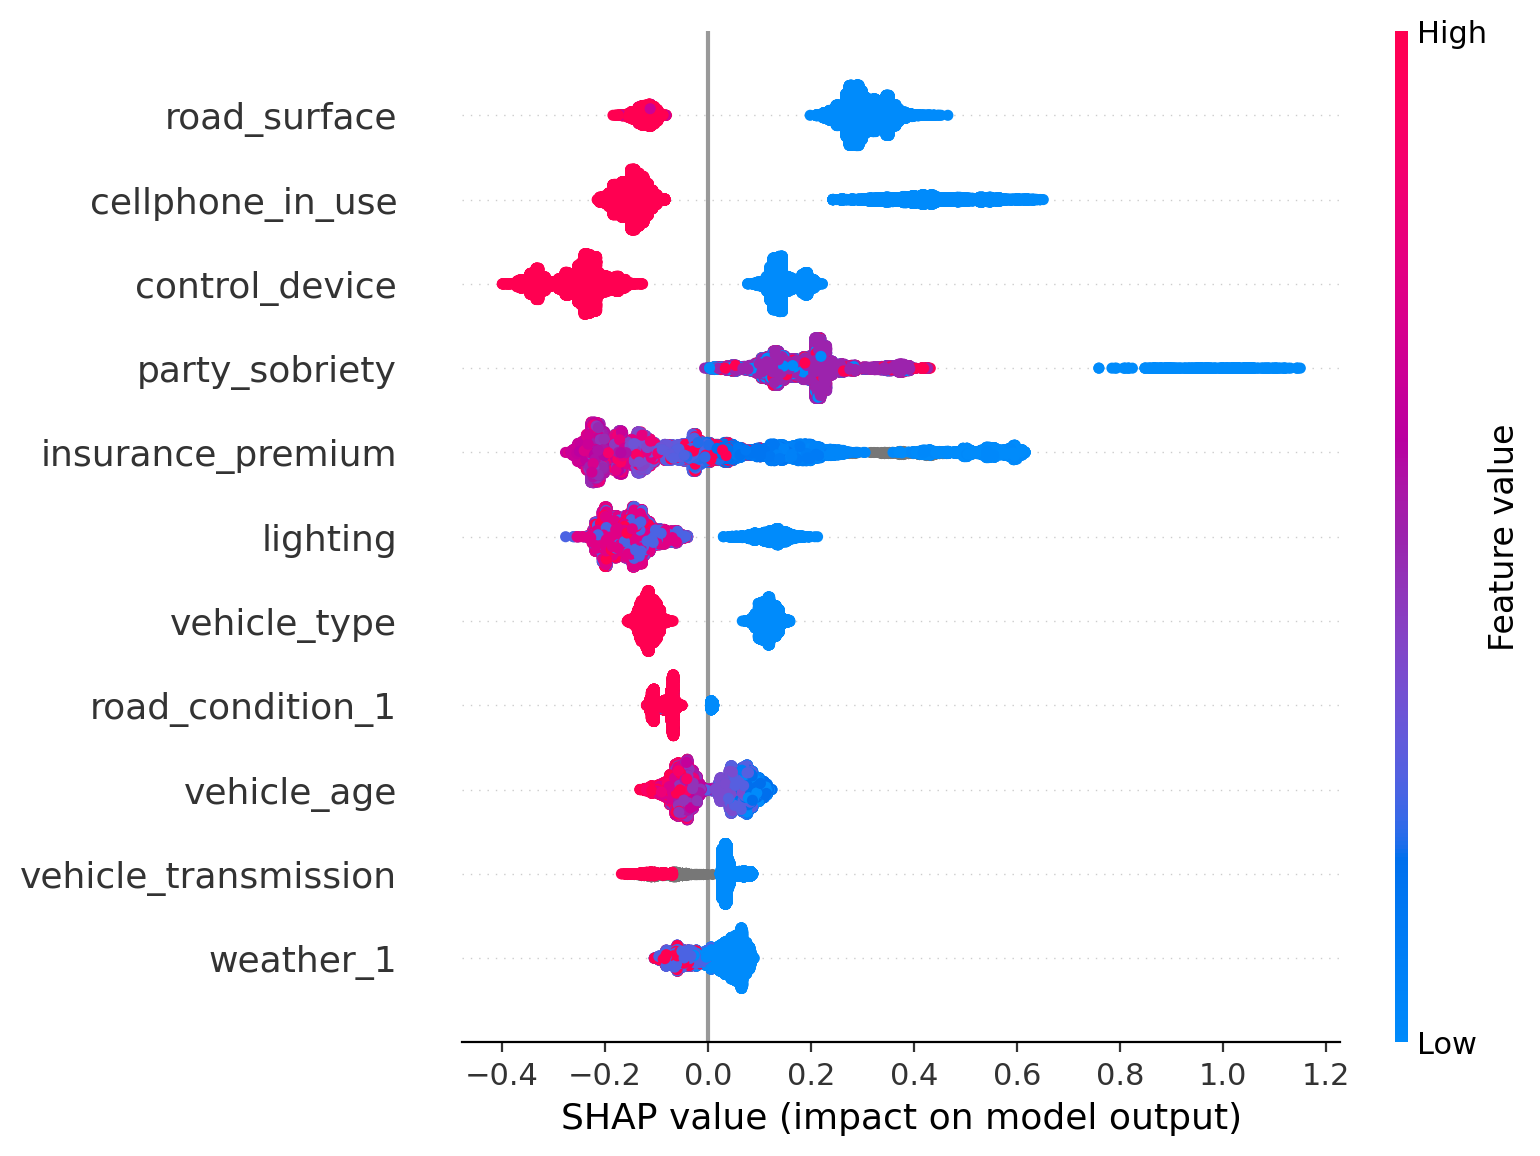

In [118]:
shap.summary_plot(shap_values, observations)

## Вывод

Кратко опишите лучшую модель.

Сделайте вывод: насколько возможно создание адекватной системы оценки риска при выдаче авто?

Какие факторы ещё необходимо собирать, чтобы улучшить модель?